# Introdução à segmentação de clientes em Python
### Exemplo de aplicação do conceito de RFM (Recency, Frequency, Monetary)
#### Por Adriano Santos

###### Base de dados utilizada: Online Retail Data Set - http://archive.ics.uci.edu/ml/datasets/online+retail

In [1]:
# Importando as bibliotecas
import pandas as pd # Para utilização de dataframe
import matplotlib.pyplot as plt # Para gerar os gráficos
import seaborn as sns # Para gerar gráficos
import datetime as dt # Para facilitar a manipulação de dados com datas
import numpy as np

pd.options.mode.chained_assignment = None

In [2]:
# Importando os dados do dataset 
df = pd.read_excel("dataset/dados.xlsx")

## Análise exploratória dos dados

In [3]:
# Analisando os primeiros dados do dataset
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
df.columns # Conhecendo as colunas

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [5]:
# Analisando as métricas iniciais dos dados
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [6]:
# Verificando a existência de dados em branco ou nulos
print( df.isnull().any() )

InvoiceNo      False
StockCode      False
Description     True
Quantity       False
InvoiceDate    False
UnitPrice      False
CustomerID      True
Country        False
dtype: bool


In [7]:
# Quantificando quantos registros em branco existem em cada dimensão
print (df.isnull().sum())

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


In [8]:
dados_faltantes = df.isnull().sum() # soma os dados faltantes do dataset
percentual_de_dados_faltantes = (dados_faltantes.sum()/ np.product(df.shape)) * 100
print ('Percentual de dados faltantes:', round (percentual_de_dados_faltantes, 2), '%')

Percentual de dados faltantes: 3.15 %


In [9]:
df_identificado = df[pd.notnull(df['CustomerID'])] # Dados com identificação do comprador
df_nao_identificado = df[pd.isnull(df['CustomerID'])] # Dados sem identificação do comprador 0 exercício futuro pra você :) 
print ('Dados com compradores identificados:', df_identificado.shape[0])
print ('Dados com compradores não identificados:', df_nao_identificado.shape[0])

Dados com compradores identificados: 406829
Dados com compradores não identificados: 135080


In [10]:
# Elimina os dados duplicados. É importante observar que um dado verdadeiramente duplicado ocorre quando TODOS as dimensões são iguais.
df_sem_duplicacoes = df_identificado.drop_duplicates() 
print ('Registros válidos:', df_sem_duplicacoes.shape)

Registros válidos: (401604, 8)


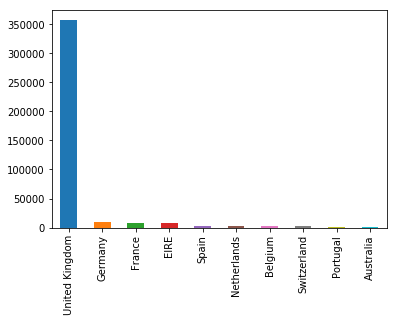

In [11]:
# Visualizando os dados dos 10 paises que mais comprou
df_sem_duplicacoes.Country.value_counts()[:10].plot(kind='bar')

In [12]:
df_sem_duplicacoes.Country.value_counts()[:15] # Apresenta os 15 pais que são maiores consumidores (em termos de quantidade de compras)

United Kingdom     356728
Germany              9480
France               8475
EIRE                 7475
Spain                2528
Netherlands          2371
Belgium              2069
Switzerland          1877
Portugal             1471
Australia            1258
Norway               1086
Italy                 803
Channel Islands       757
Finland               695
Cyprus                611
Name: Country, dtype: int64

In [13]:
# Obtendo a lista dos 10 paises que mais consomem (por volume total de vendas) 
df_sem_duplicacoes['Total'] = df_sem_duplicacoes.UnitPrice * df_sem_duplicacoes.Quantity 
df_sem_duplicacoes_CQT = df_sem_duplicacoes[['Country', 'Quantity', 'Total']]
volume_de_venda = df_sem_duplicacoes_CQT.groupby('Country').sum().sort_values('Total', ascending=False).head(10)
volume_de_venda

,Quantity,Total
Country,,
United Kingdom,3994870,6.747156e+06
Netherlands,200128,2.846615e+05
EIRE,136187,2.500018e+05
Germany,117341,2.215095e+05
France,109806,1.966260e+05
Australia,83643,1.370098e+05
Switzerland,29778,5.573940e+04
Spain,26817,5.475603e+04
Belgium,23152,4.091096e+04


### Análise dos registros com comportamentos anômalos

Considere dados anômalos, os dados que possuem valores de quantidade menores do que 0 (zero). Isso pode ter vários motivos. O primeiro deles é analisar se o comprador fez a compra e, depois, por algum motivo, resolveu devolver. Um segundo possível motivo é quando a empresa envia um produto para o consumidor sem que ocorra compra. Ex: premiação, promoções etc.

In [14]:
df_dados_anomalos = df_sem_duplicacoes[ df_sem_duplicacoes.Quantity < 0 ] # obtem dados com comportamento anômalos
df_dados_anomalos.head().sort_values('Total', ascending=False)
# O desconto StockCode=D é o maior valor entre os dados anômalos

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom,-4.65
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,-6.96
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,-6.96
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom,-19.80
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom,-27.50


In [15]:
# Ordenando os dados por consumidores e totais.
print ('Os 10 consumidores que mais impactaram negativamente na empresa.')
df_dados_anomalos = df_dados_anomalos[['CustomerID', 'Total']]
print (df_dados_anomalos.groupby('CustomerID').sum().sort_values('Total', ascending=False).head(10)) # Obtendo os 10 maiores
print ('Número total de consumidores: {}'.format(df_dados_anomalos.CustomerID.count()))
print ('Valor total consumido: {}'.format(df_dados_anomalos.Total.sum()))

Os 10 consumidores que mais impactaram negativamente na empresa.
            Total
CustomerID       
17334.0     -0.42
15903.0     -0.42
16566.0     -0.65
12421.0     -0.77
17164.0     -0.95
16473.0     -1.25
17521.0     -1.25
16995.0     -1.25
12665.0     -1.25
12933.0     -1.25
Número total de consumidores: 8872
Valor total consumido: -608689.47


In [16]:
# Analisando o comportamento do consumidor de id 16446
df_CustomerID = df_sem_duplicacoes[df_sem_duplicacoes.CustomerID == 16446.0]
df_CustomerID
# Perceba que o produto 23843 foi 'comprado' e foi 'devolvido'

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total
194354,553573,22980,PANTRY SCRUBBING BRUSH,1,2011-05-18 09:52:00,1.65,16446.0,United Kingdom,1.65
194355,553573,22982,PANTRY PASTRY BRUSH,1,2011-05-18 09:52:00,1.25,16446.0,United Kingdom,1.25
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446.0,United Kingdom,168469.60
540422,C581484,23843,"PAPER CRAFT , LITTLE BIRDIE",-80995,2011-12-09 09:27:00,2.08,16446.0,United Kingdom,-168469.60


In [17]:
# Eliminando as vendas que não se concretizaram
mascara = df_sem_duplicacoes [['StockCode', 'Description', 'UnitPrice', 'CustomerID']].duplicated(keep=False)
df_sem_duplicacoes_final =  df_sem_duplicacoes[~mascara]
df_CustomerID = df_sem_duplicacoes_final[df_sem_duplicacoes_final.CustomerID == 16446.0]
df_CustomerID
# Perceba que os dados sobre compras não concretizadas foram removidos.

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total
194354,553573,22980,PANTRY SCRUBBING BRUSH,1,2011-05-18 09:52:00,1.65,16446.0,United Kingdom,1.65
194355,553573,22982,PANTRY PASTRY BRUSH,1,2011-05-18 09:52:00,1.25,16446.0,United Kingdom,1.25


In [18]:
# Com base no dataset que contem os dados de transações com consumidores identificados, vamos analisar o consumidor de 17548.0
df_identificado[df_identificado.CustomerID == 17548.0] # Problemático... 

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
238,C536391,21980,PACK OF 12 RED RETROSPOT TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
239,C536391,21484,CHICK GREY HOT WATER BOTTLE,-12,2010-12-01 10:24:00,3.45,17548.0,United Kingdom
240,C536391,22557,PLASTERS IN TIN VINTAGE PAISLEY,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
241,C536391,22553,PLASTERS IN TIN SKULLS,-24,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
165024,550755,22585,PACK OF 6 BIRDY GIFT TAGS,24,2011-04-20 12:01:00,1.25,17548.0,United Kingdom
165025,550755,22082,RIBBON REEL STRIPES DESIGN,10,2011-04-20 12:01:00,1.65,17548.0,United Kingdom
165026,550755,22081,RIBBON REEL FLORA + FAUNA,10,2011-04-20 12:01:00,1.65,17548.0,United Kingdom


### RFM (Recency, Frequency, Monetary)


* Recency: calcula o número de dias entre o dia base (última compra + 1) e a última compra por cada consumidor.
* Frequency: calcula o número de compras realizadas por cada consumidor
* Monetary: calcula o valor total pago por cada consumidor.


In [19]:
# Agora, utilizaremos apenas os dados de compras efetivadas e com compradores identificados.
df_rfm = df_sem_duplicacoes_final[df_sem_duplicacoes_final.Quantity > 0] 
df_rfm.describe()

,Quantity,UnitPrice,CustomerID,Total
count,211946.000000,211946.000000,211946.000000,211946.000000
mean,11.199155,3.015089,15287.584772,17.877321
std,42.550645,12.780545,1711.293600,54.369034
min,1.000000,0.000000,12347.000000,0.000000
25%,2.000000,0.850000,13850.000000,4.950000
50%,6.000000,1.690000,15253.000000,11.700000
75%,12.000000,3.750000,16788.000000,17.700000
max,12540.000000,2500.000000,18287.000000,7144.720000


In [20]:
# Realizando operações de conversão e obtenção dos valores extremos da dimensão data
df_rfm['InvoiceDate'] = pd.to_datetime(df_rfm['InvoiceDate']) # Converte o campo para o tipo data
menor_data, maior_data = df_rfm['InvoiceDate'].min(), df_rfm['InvoiceDate'].max() # Obtemos o dia da primeira e da última compra
maior_data = maior_data + pd.DateOffset(days=1) # Agora, adicionamos um dia à maior compra para iniciarmos a análise.

In [21]:
# Só por curiosidade... quais foram os produtos que foram mais comprados primeiro durante os dias. :)
((df_rfm.groupby(['InvoiceDate']).first()).groupby('Description').count().sort_values('Quantity', ascending=False).head(10))['Quantity']

Description
REGENCY CAKESTAND 3 TIER              87
Manual                                77
DOORMAT KEEP CALM AND COME IN         72
RABBIT NIGHT LIGHT                    62
PARTY BUNTING                         58
WHITE HANGING HEART T-LIGHT HOLDER    58
JUMBO BAG RED RETROSPOT               55
PAPER CHAIN KIT 50'S CHRISTMAS        46
POSTAGE                               45
SET OF 3 REGENCY CAKE TINS            43
Name: Quantity, dtype: int64

In [22]:
# Agora, quando tivemos as dez maiores vendas
df_rfm.groupby('InvoiceDate')[['Total']].sum().sort_values('Total', ascending=False)[:10] 

,Total
InvoiceDate,
2011-09-20 10:12:00,21181.28
2011-10-21 12:08:00,18921.00
2011-04-18 13:20:00,14996.50
2011-09-20 11:05:00,14406.52
2011-06-15 13:37:00,12038.78
2011-08-18 08:51:00,11594.04
2011-10-05 12:44:00,11498.96
2011-05-12 14:46:00,9197.26
2011-12-07 12:14:00,8345.20


In [23]:
# Vamos saber quais foram os produtos mais vendidos (quantidade de vezes)
print ('Produtos mais vendidos (quantidade)')
print (df_rfm.groupby('Description')[['Quantity', 'Total']].sum().sort_values('Quantity', ascending=False)[:10])  
print('*****************************************')
print ('Produtos mais vendidos (valor)')
# Vamos saber quais foram os produtos mais vendidos (quantidade por valor)
print (df_rfm.groupby('Description')[['Quantity', 'Total']].sum().sort_values('Total', ascending=False)[:10])  

# Caso você deseje saber o menos vendido, basta mudar a ordenação.

Produtos mais vendidos (quantidade)
                                    Quantity     Total
Description                                           
WORLD WAR 2 GLIDERS ASSTD DESIGNS      17880   4591.92
ASSORTED COLOURS SILK FAN              15756  11204.36
ASSTD DESIGN 3D PAPER STICKERS         13509    340.53
PACK OF 72 RETROSPOT CAKE CASES        11048   5702.00
JUMBO BAG RED RETROSPOT                10494  19622.91
BROCADE RING PURSE                      8278   2242.90
ASSORTED COLOUR BIRD ORNAMENT           7715  12335.63
60 CAKE CASES VINTAGE CHRISTMAS         7522   3715.90
WHITE HANGING HEART T-LIGHT HOLDER      7458  19867.20
POPART WOODEN PENCILS ASST              7400    320.00
*****************************************
Produtos mais vendidos (valor)
                                     Quantity     Total
Description                                            
REGENCY CAKESTAND 3 TIER                 2199  25835.95
WHITE HANGING HEART T-LIGHT HOLDER       7458  19867.20
PARTY B

In [24]:
# Divide em quatro períodos para análise
periodoA, periodoB, periodoC, periodoD = pd.date_range(menor_data, maior_data, periods=4)

In [25]:
tabela_rfm = df_rfm.groupby('CustomerID').agg({'InvoiceDate': lambda date: (maior_data - date.max()).days,
                                        'InvoiceNo': lambda num: len(num),
                                        'Total': lambda valor: valor.sum()})
tabela_rfm.head(6).sort_values('Total', ascending=False)

,InvoiceDate,InvoiceNo,Total
CustomerID,,,
12349.0,19,73,1757.55
12347.0,2,64,1597.03
12348.0,249,23,947.24
12352.0,36,44,762.88
12350.0,310,17,334.40
12353.0,204,4,89.00


In [26]:
# Renomeando as colunas de acordo com a análise de RFM
tabela_rfm.columns=['recency','frequency','monetary']
# Visualizando os consumidores que mais compraram na loja
tabela_rfm.head().sort_values('frequency', ascending=False)

# TODO: Criar gráfico de dispersão em para o consumidor 12349.

,recency,frequency,monetary
CustomerID,,,
12349.0,19,73,1757.55
12347.0,2,64,1597.03
12352.0,36,44,762.88
12348.0,249,23,947.24
12350.0,310,17,334.40


In [27]:
# Classificando os dados de acordo com quartis 
tabela_rfm['recency_quartile'] = pd.qcut(tabela_rfm['recency'], 4, ['1','2','3','4']) # mais recente, mais importante
tabela_rfm['frequency_quartile'] = pd.qcut(tabela_rfm['frequency'], 4, ['4','3','2','1']) # menos frequencia, menos importante
tabela_rfm['monetary_quartile'] = pd.qcut(tabela_rfm['monetary'], 4, ['4','3','2','1']) # menos consumo, manos importante

In [28]:
# Visualizando o resultado
tabela_rfm.head()

# Com essa formação você pode realizar diversas análise (quem comprou mais, quem compra com maior frequência etc.)

,recency,frequency,monetary,recency_quartile,frequency_quartile,monetary_quartile
CustomerID,,,,,,
12347.0,2,64,1597.03,1,2,1
12348.0,249,23,947.24,4,3,2
12349.0,19,73,1757.55,1,1,1
12350.0,310,17,334.40,4,3,3
12352.0,36,44,762.88,2,2,2


In [29]:
tabela_rfm['Score'] = tabela_rfm.recency_quartile.astype(str) + tabela_rfm.frequency_quartile.astype(str) + tabela_rfm.monetary_quartile.astype(str)
tabela_rfm.head()

,recency,frequency,monetary,recency_quartile,frequency_quartile,monetary_quartile,Score
CustomerID,,,,,,,
12347.0,2,64,1597.03,1,2,1,121
12348.0,249,23,947.24,4,3,2,432
12349.0,19,73,1757.55,1,1,1,111
12350.0,310,17,334.40,4,3,3,433
12352.0,36,44,762.88,2,2,2,222
